In [1]:
# Asset Exchange Models

using StatsBase, Printf, Plots
gr()

"""
Yard Sale Model

βh  : Proportion won by the poorer player and lost by the richer, 0 < `high` < 1.
βl  : Proportion won by the richer player and lost by the pooer, 0 < `low` < 1.
pop : Number of agents in population.
stat: A function that calculates a statistic based on the wealth vector, e.g. `maxstat`.
n   : The number of exchanges to run.
"""
function ysm(βh, βl, pop, stat, n)
    wealth = ones(Float64, pop)
    stats = Vector{Float64}(undef, n)
    for i = 1:n
        # choose 2 agents from the population
        p = sample(1:pop, 2, replace=false)
        (poor, rich) = wealth[p[1]] <= wealth[p[2]] ? (p[1], p[2]) : (p[2], p[1])
        flip = rand(Bool) # true if poorer player wins.
        minw = wealth[poor]
        if flip
            wealth[poor] += βh * minw
            wealth[rich] -= βh * minw
        else
            wealth[poor] -= βl * minw
            wealth[rich] += βl * minw
        end
        stats[i] = stat(wealth)
    end
    wealth, stats
end

"""
Extended Yard Sale Model (like imposing a wealth tax)

β   : Proportion won or lost.
τ   : Wealth tax rate.
pop : Number of agents in population.
stat: A function that calculates a statistic based on the wealth vector, e.g. `maxstat`.
n   : The number of exchanges to run.
"""
function eysm(β, τ, pop, stat, n)
    wealth = ones(Float64, pop)
    stats = Vector{Float64}(undef, n)
    for i = 1:n
        # choose 2 agents from the population
        p = sample(1:pop, 2, replace=false)
        η = rand([-1, 1])
        minw = min(wealth[p[1]], wealth[p[2]])
        Δw = τ * (1 - wealth[p[1]]) + β * minw * η
        wealth[p[1]] += Δw
        wealth[p[2]] -= Δw
        stats[i] = stat(wealth)
    end
    wealth, stats
end

#
# `stat` Functions
#

""" Percent wealth of the richest agent. """
maxstat(w) = 100 * maximum(w) / length(w)

""" Percent wealth of the poorsest agent. """
minstat(w) = 100 * minimum(w) / length(w)

""" Don't caluculate any statistic. """
nostat(w) = 0.0

""" Percentage of wealth for the top (bottom) `p` proportion of agents. """
function percentstat(p; top=true)
    function (w)
        sort!(w, rev=top)
        n = length(w)
        m = Int(n * p)
        s = 0.0
        for i in 1:m
            s += w[i]
        end
        s / n
    end
end

""" Caculate cummulative for lorenz curve, and calculate the Gini Coefficient. """
function lorenz(wealth)
    sort!(wealth)
    n = length(wealth) # total amount of wealth, since each agent starts with 1.0.
    result = Vector{Tuple{Float64, Float64}}(undef, n)
    x = 0.0
    t = 0.0
    for i = 1:n
        x += 1.0 / n
        t += wealth[i] / n
        result[i] = (x, t)
    end
    g = map(x -> x[2], result) |> sum
    (result, 1 - 2 * g / n) # (result, gini coefficient)
end

""" Plot the lorenz curve for the wealth vector. """
function lorenzplot(wealth)
    (w, g)  = lorenz(wealth)
    gini = @sprintf("Gini Coefficient = %0.2f", abs(g))
    plot( w, 
          xlabel="Cummulative share of people", 
          ylabel="Cummulative share of wealth",
          title="Lorenz Curve",
          legend=false,
          fill=(0, :orange),
          linewidth=2,
          annotations = (0.5, 0.5, gini)
        )
end

""" Plot the statistic for each 1000 exchanges. """
function plotstat(stats)
    plot(stats[1:1_000:end], 
        xlabel="Transactions (1,000s)", 
        ylabel="Percentage held by wealthiest person", 
        legend=false
    )
end;

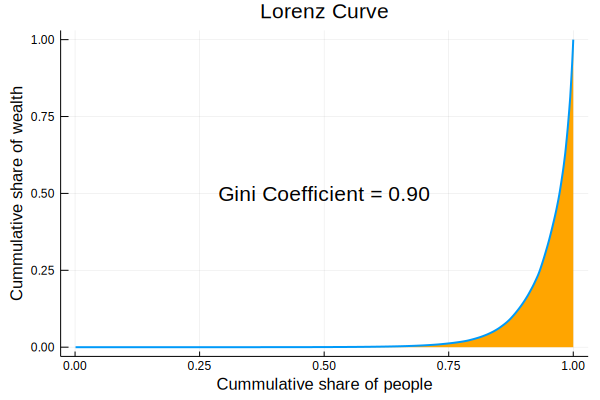

In [2]:
(w, _) = ysm(0.2, 0.17, 1000, nostat, 1_000_000)
lorenzplot(w)

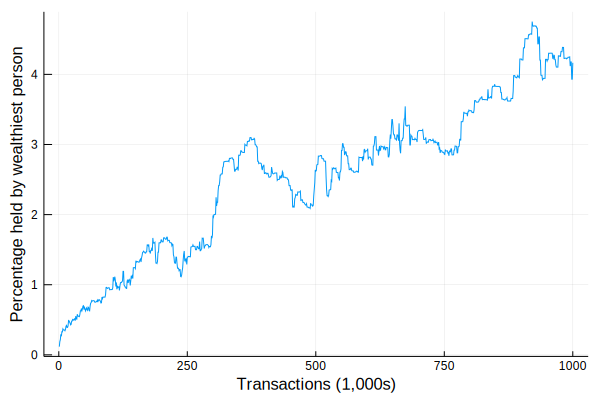

In [3]:
(_, mmax) = ysm(0.2, 0.17, 1000, maxstat, 1_000_000);
plotstat(mmax)

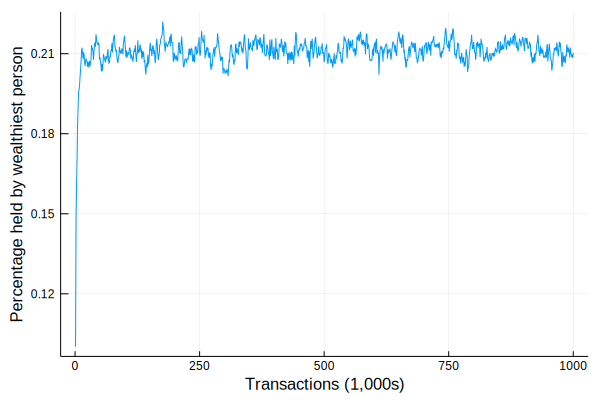

In [4]:
(_, mmax2) = eysm(0.2, 0.1, 1000, percentstat(0.1), 1_000_000);
plotstat(mmax2)

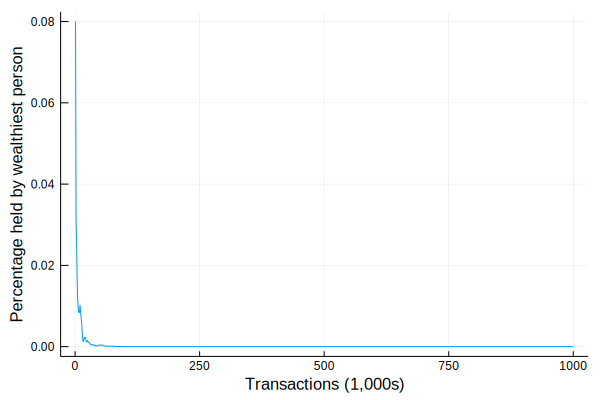

In [5]:
(_, mmin) = ysm(0.2, 0.17, 1000, minstat, 1_000_000);
plotstat(mmin)

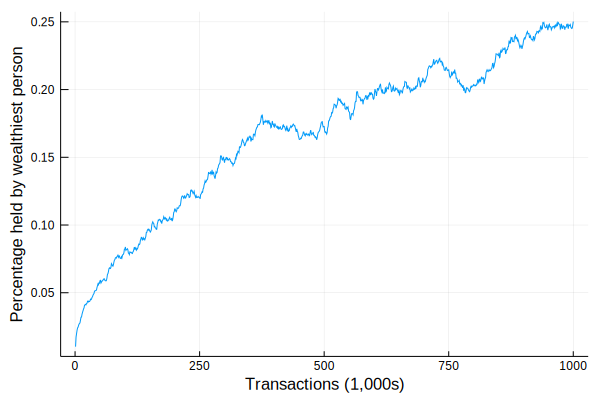

In [6]:
(_, top1) = ysm(0.2, 0.17, 1000, percentstat(0.01), 1_000_000);
plotstat(top1)

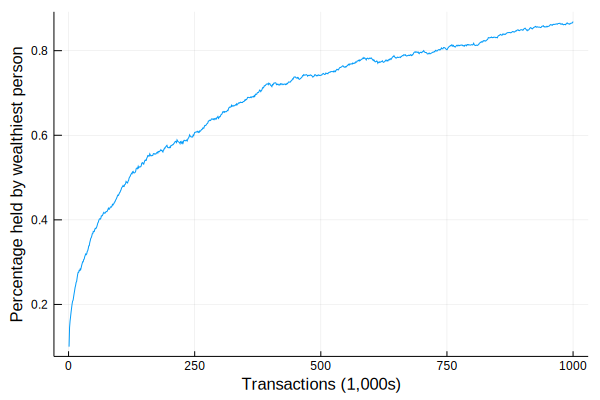

In [7]:
(_, top10) = ysm(0.2, 0.17, 1000, percentstat(0.1), 1_000_000);
plotstat(top10)